**Loan Repayment Prediction Analysis**
<br>Source : https://www.kaggle.com/laotse/credit-risk-dataset

# Library

In [1]:
#Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#Simple Statistic & Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Statistic
from scipy.stats import normaltest
from scipy.stats import chi2_contingency
import pingouin as pg

#Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Imbalance
from imblearn.under_sampling import RandomUnderSampler, NearMiss

#Encode
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

#Preprocessing
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#Scalling
from sklearn.preprocessing import RobustScaler

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

#Explaination
import shap

#Hyperparameter
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

# Problem Statement

**Context**
<p style='text-align: justify;'> Credit risk refers to the uncertainty faced by an organization while lending money to an individual, business, or organization. Credit risk analysis is defined as a detailed review, and inspection done by the lending organization regarding the borrower about their financial background, modes of earning, and the capability to repay the borrowed credit. This gives the lending enterprises a fair idea regarding the credit-paying capabilities of the borrower. In simple terms, credit risk refers to the potential for loss due to the failure of a borrower to make a payment when it is due. The risk is mainly for the lender and it can include complete or partial loss of principal amount, loss of interest, and disruption of cash flow.</p>

**Problem Statement**

<p style='text-align: justify;'>The purpose of credit risk analysis is to determine the creditworthiness of the borrower based on his financial background and repayment history and capacity. It means to determine the eligibility of the person to receive the amount of money he is requesting without causing any kind of complete or partial loss to the lending organization. Having a credit risk analysis done provides lenders with a complete profile of the customer and an insight that enables them to anticipate customer behavior. By employing various analytics techniques, lenders can save their time, money, and resources to target the right customers and monitor or anticipate the risk involved for a more profitable business. But to achieve that purpose we need the model to predict which borrower will repay or not. </p>

**Goals**

To know which borrower will repay or not so the company can prevent the loss because of the borrower not repay and keep the borrower who can repay still can lend the money.

**Matrix Evaluation:**

<img src='Matrix.png'>

**Consequencies :**

Type 1 error : False Positive  
Consequences: Company can't get profit

Type 2 error : False Negative  
Consequences: Company get loss

Based on that consequences we want to minimize type 2 error because our goal is to prevent the loss from borrower who will not repay, so we will focus to **False Negative** and using **Recall** matrix
<br> Source : https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/

# Data Understanding

In [2]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


**Data Explaination**

* person_age : Age
* person_income : Annual Income
* personhomeownership : Home ownership
* personemplength : Employment length (in years)
* loan_intent : Loan intent
* loan_grade : Loan grade
* loan_amnt : Loan amount
* loan_int_rate : Interest rate
* loan_status : Loan status (0 is non default 1 is default)
* loanpercentincome :	Percent income
* cbpersondefaultonfile :	Historical default
* cbpresoncredhistlength : Credit history length

In [3]:
#Reordering columns
column_names_reordered = ['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length', 'loan_status',]
df=df[column_names_reordered]
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,4,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_cred_hist_length  32581 non-null  int64  
 10  loan_status                 32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


In [5]:
# Numerical
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.170203,5.804211,0.218164
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.106782,4.055001,0.413006
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.230000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [6]:
# Object
df.describe(include=object)

,person_home_ownership,loan_intent,loan_grade
count,32581,32581,32581
unique,4,6,7
top,RENT,EDUCATION,A
freq,16446,6453,10777


In [7]:
print(f'''This Dataset has features:

Categorical Features : {len(df.describe(include=object).columns)}
Numerical Features : {len(df.describe().columns)}

This Dataset has {len(df.columns)} Features
''')

This Dataset has features:

Categorical Features : 3
Numerical Features : 8

This Dataset has 11 Features



# Exploratory Dataset Analysis (EDA)

## Distribution Data Numerical

In [8]:
# Numerical
numeric = df.select_dtypes(include='number').drop(columns="loan_status")
numeric.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,22,59000,123.0,35000,16.02,0.59,3
1,21,9600,5.0,1000,11.14,0.10,2
2,25,9600,1.0,5500,12.87,0.57,3
3,23,65500,4.0,35000,15.23,0.53,2
4,24,54400,8.0,35000,14.27,0.55,4


In [9]:
# Categorical
cat = df.select_dtypes(include='object')
cat.head()

,person_home_ownership,loan_intent,loan_grade
0,RENT,PERSONAL,D
1,OWN,EDUCATION,B
2,MORTGAGE,MEDICAL,C
3,RENT,MEDICAL,C
4,RENT,MEDICAL,C


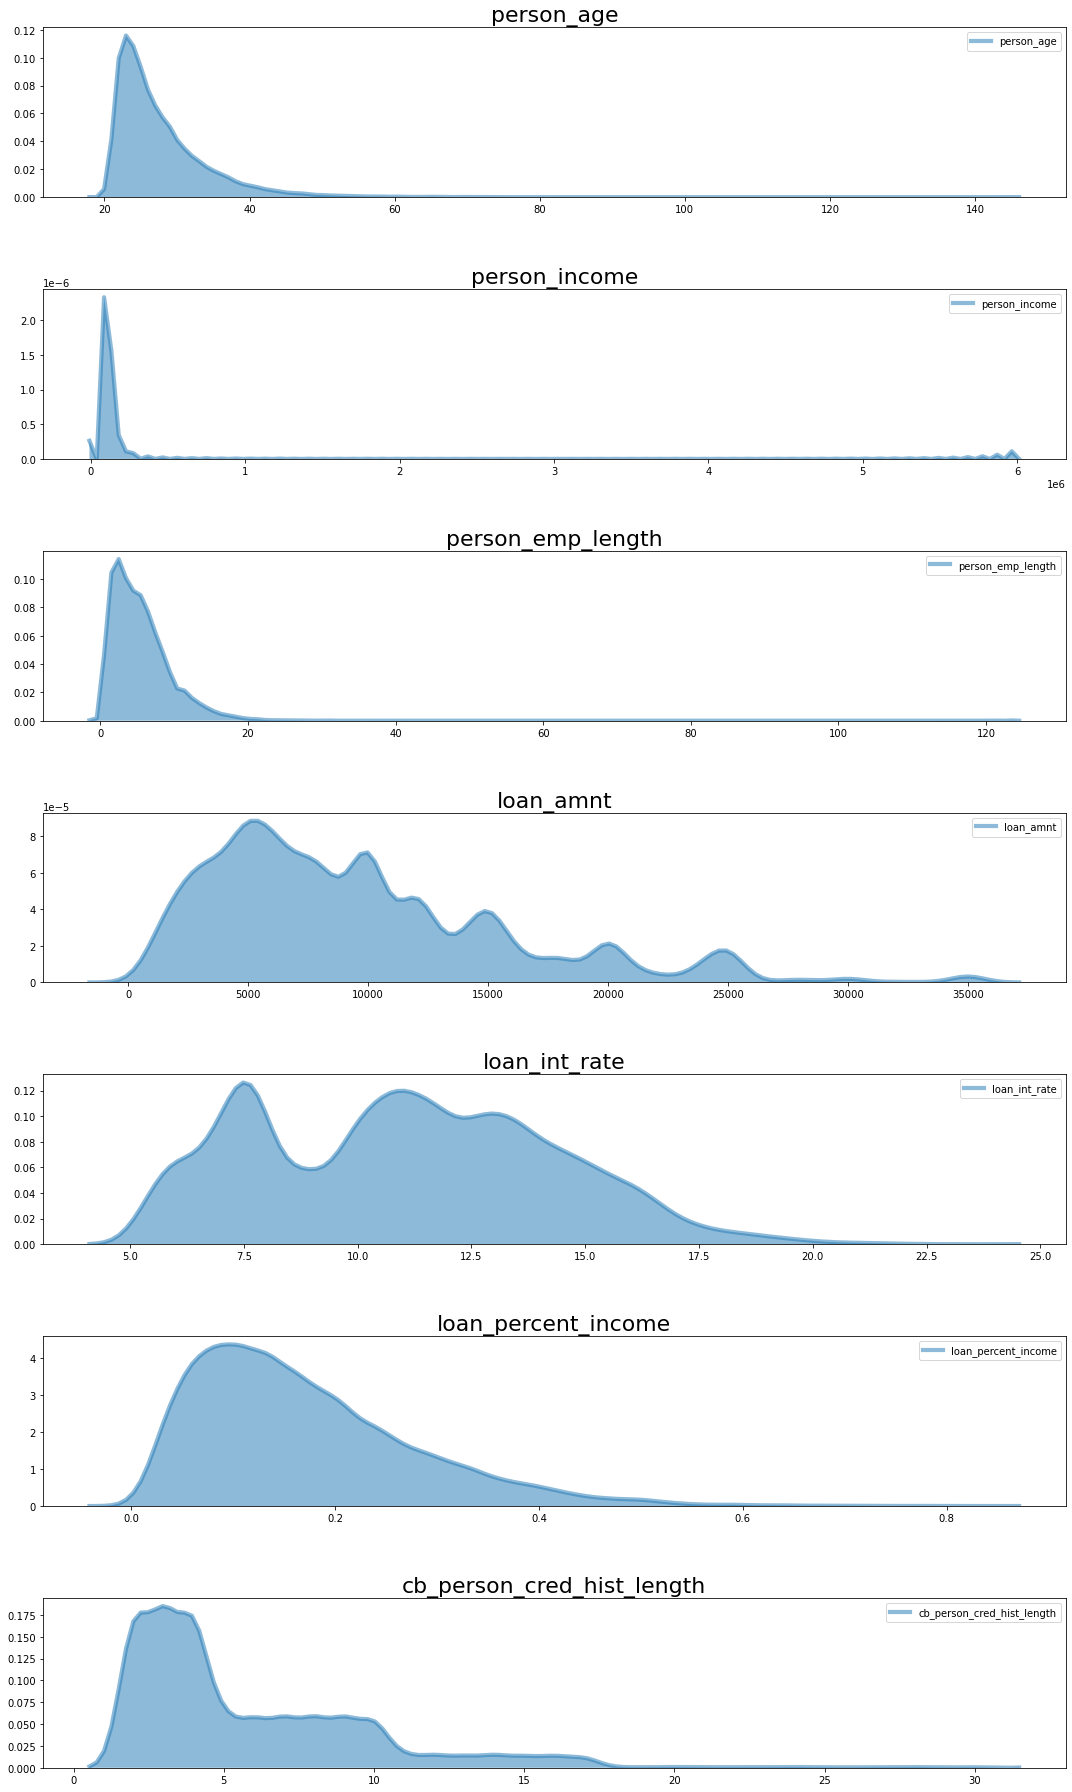

In [10]:
# Visualization Data Distribution
plt.figure(figsize=(15,25))
a = 1

for i in list(numeric.columns):
    plt.subplot(7,1,a)
    sns.kdeplot(df[i],shade=True, 
                 alpha=.5, linewidth=4.2)
    plt.title(i,fontsize=22)
    a+=1
    plt.tight_layout(h_pad=4)

plt.show()

In [11]:
# Normal Test
for i in list(numeric.columns):
    stats, pval = normaltest(df[i])
    if pval > 0.05:
        print(i, ': Normal distribution')
    else:
        print(i, ': Not normal distribution')

person_age : Not normal distribution
person_income : Not normal distribution
person_emp_length : Not normal distribution
loan_amnt : Not normal distribution
loan_int_rate : Not normal distribution
loan_percent_income : Not normal distribution
cb_person_cred_hist_length : Not normal distribution


## Data Cardinalities

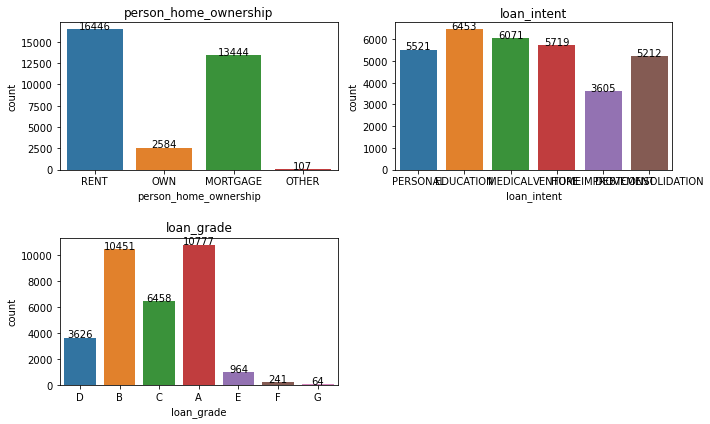

In [12]:
plt.figure(figsize=(10,6))

A = 0
for i in cat:
    A+=1
    plt.subplot(2,2,A)
    ax = sns.countplot(data=df.fillna('NaN'), x=i)
    plt.title(i, fontsize=12)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=10)
plt.tight_layout(h_pad=2)

## Data Correlation

### Categorical Variable

#### WOE & IV

In [13]:
category = list(cat)
for i in category:
    df_woe_iv = (pd.crosstab(df[i],df['loan_status'], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    print(df_woe_iv,'\n------------------------------------------------------------')

loan_status                   0         1       woe        iv
person_home_ownership                                        
MORTGAGE               0.461430  0.237760 -0.663067  0.376998
OTHER                  0.002905  0.004643  0.468841  0.376998
OWN                    0.093864  0.027153 -1.240379  0.376998
RENT                   0.441801  0.730445  0.502794  0.376998 
------------------------------------------------------------
loan_status               0         1       woe        iv
loan_intent                                              
DEBTCONSOLIDATION  0.146115  0.209623  0.360913  0.095752
EDUCATION          0.209712  0.156303 -0.293941  0.095752
HOMEIMPROVEMENT    0.104581  0.132386  0.235757  0.095752
MEDICAL            0.174695  0.228053  0.266537  0.095752
PERSONAL           0.173635  0.154474 -0.116930  0.095752
VENTURE            0.191261  0.119162 -0.473161  0.095752 
------------------------------------------------------------
loan_status         0         1       wo

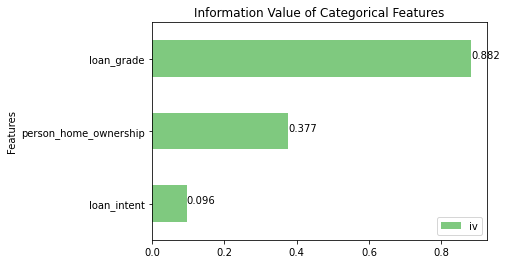

In [14]:
iv = []
for i in category:
    df_woe_iv = (pd.crosstab(df[i],df['loan_status'], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv.append(df_woe_iv['iv'][0])

df_iv = pd.DataFrame({'Features':category,'iv':iv}).set_index('Features').sort_values(by='iv')
df_iv.plot(kind='barh', title='Information Value of Categorical Features',colormap = "Accent")
for index, value in enumerate(list(round(df_iv["iv"],3))):
    plt.text((value), index,
             str(value))
plt.legend(loc="lower right")
plt.show()

#### Chi Squared

Hypothesis
* Ho : There is no relation between feature and target
* Ha : There is a relation between feature and target

In [15]:
for i in cat:
    chisqt = pd.crosstab(df["loan_status"], df[i], margins=True)
    value = np.array([chisqt.iloc[0],
                      chisqt.iloc[1]])
    stat,pval,dof,exp = chi2_contingency(value)
    alpha = 0.05
    if pval <= alpha:
        print(i, ": Dependent (reject H0)")
    else:
        print(i, ": Independent (H0 holds true)")

person_home_ownership : Dependent (reject H0)
loan_intent : Dependent (reject H0)
loan_grade : Dependent (reject H0)


### Categorical Variable and Numerical Variable

In [17]:
# ETA Squared
num_list = list(numeric.columns)
for i in num_list:
    print(i)
    print(pg.compute_effsize(df["loan_status"], df[i], eftype='eta-square'),"\n")

person_age
0.903426609779522 

person_income
0.3623216607710891 

person_emp_length
0.37936128974614436 

loan_amnt
0.5349477447059625 

loan_int_rate
0.8515792235747401 

loan_percent_income
0.00628038849576135 

cb_person_cred_hist_length
0.4842987854864742 



## Identify Missing Values

In [18]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

## Data Imbalance

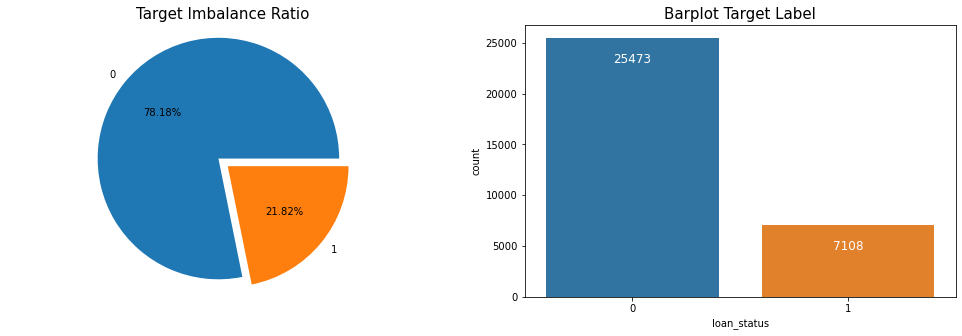

In [19]:
plt.figure(figsize=(17,(100)/20))

plt.subplot(121)
plt.pie(round(df['loan_status'].value_counts()/len(df)*100,2),labels=list(df['loan_status'].value_counts().index),autopct = "%.2f%%",explode = (0,0.1))
plt.axis("equal")
plt.title("Target Imbalance Ratio",size=15)

plt.subplot(122)
ax = sns.countplot(data=df, x='loan_status')
plt.title("Barplot Target Label", fontsize=15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

## Identify Outliers

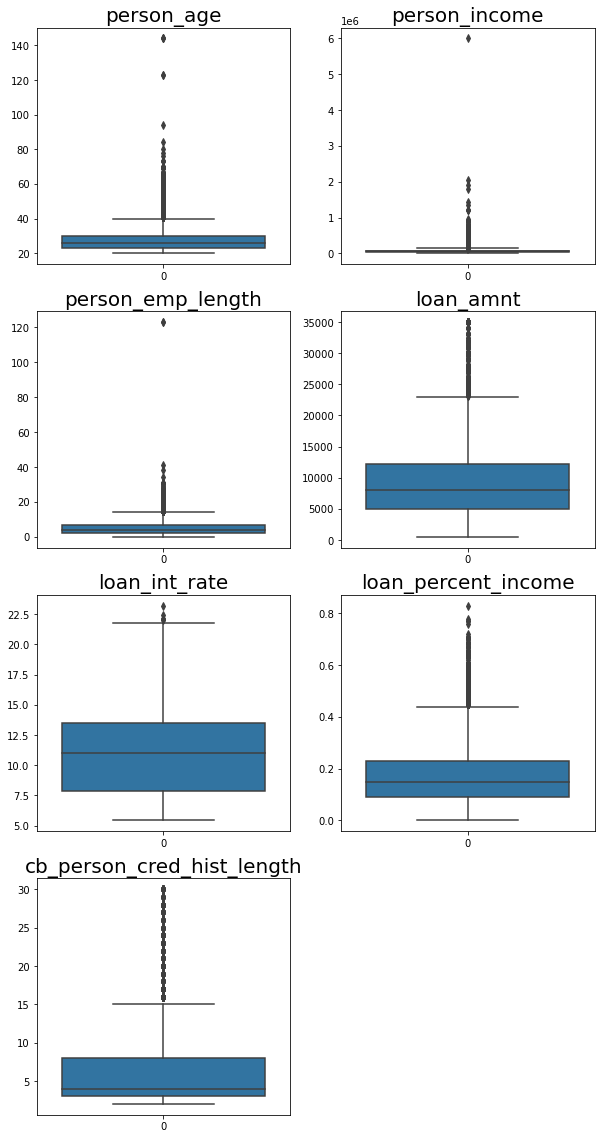

In [20]:
plt.figure(figsize=(10,20))
a = 1

for i in numeric:
    plt.subplot(4,2,a)
    sns.boxplot(data = df[i])
    plt.title(i,fontsize=20)
    a+=1

plt.show()

# Preprocessing

## Inconsistent Variable

In [21]:
df.sort_values(by=['person_age'],ascending=False)["person_age"].head(10)

81       144
32297    144
183      144
747      123
575      123
32416     94
32506     84
32422     80
32355     78
32534     76
Name: person_age, dtype: int64

In [22]:
df.sort_values(by=['person_emp_length'],ascending=False)["person_emp_length"]

0        123.0
210      123.0
32355     41.0
32515     38.0
32428     34.0
         ...  
32285      NaN
32328      NaN
32360      NaN
32453      NaN
32471      NaN
Name: person_emp_length, Length: 32581, dtype: float64

In [23]:
# Deleting Inconsistent row
df.drop([81,32297,183,747,575,210,0],inplace=True)
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,4,1
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,2,1


## Fill Missing Values

In [24]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_percent_income              0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [25]:
#Itterative Imputer (person_emp_length)
iter_imp=IterativeImputer(max_iter=10,random_state=0)
df[["person_emp_length"]]=iter_imp.fit_transform(df[["person_emp_length"]])
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,4,1
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,2,1


In [26]:
#Itterative Imputer (person_emp_length)
iter_imp=IterativeImputer(max_iter=10,random_state=0)
df[["loan_int_rate"]]=iter_imp.fit_transform(df[["loan_int_rate"]])
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,4,1
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,2,1


In [27]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

## Export Preprocessing Dataset

In [28]:
df.to_csv("Preprocessing Loan Repayment Dataset.csv",index=False)

## Transform

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32574 entries, 1 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           32574 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               32574 non-null  float64
 8   loan_percent_income         32574 non-null  float64
 9   cb_person_cred_hist_length  32574 non-null  int64  
 10  loan_status                 32574 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 3.0+ MB


In [30]:
#Loan grade has ordinal categorical type
ordinal_mapping=[
    {"col":"loan_grade",
    "mapping": {"G":1,"F":2,"E":3,"D":4,"C":5,"B":6,"A":7}}]

In [31]:
#Transform without scalling
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(), ["loan_intent","person_home_ownership"]),
    ("ordinal", ce.OrdinalEncoder(mapping=ordinal_mapping), ["loan_grade"])
], remainder='passthrough')

In [32]:
#Transform with scalling
transformer_sc = ColumnTransformer([
    ("scalling",RobustScaler(),list(numeric.columns)),
    ('one hot', OneHotEncoder(), ["loan_intent","person_home_ownership"]),
    ("ordinal", ce.OrdinalEncoder(mapping=ordinal_mapping), ["loan_grade"])
], remainder='passthrough')

## Splitting

In [33]:
x = df.drop(columns=["loan_status"])
y = df["loan_status"]
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=.2,random_state=2020)

## Get Feature Names

In [34]:
transformer.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(),
                                 ['loan_intent', 'person_home_ownership']),
                                ('ordinal',
                                 OrdinalEncoder(mapping=[{'col': 'loan_grade',
                                                          'mapping': {'A': 7,
                                                                      'B': 6,
                                                                      'C': 5,
                                                                      'D': 4,
                                                                      'E': 3,
                                                                      'F': 2,
                                                                      'G': 1}}]),
                                 ['loan_grade'])])

In [35]:
transformer.transformers_

[('one hot', OneHotEncoder(), ['loan_intent', 'person_home_ownership']),
 ('ordinal',
  OrdinalEncoder(cols=['loan_grade'],
                 mapping=[{'col': 'loan_grade',
                           'mapping': {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3,
                                       'F': 2, 'G': 1}}]),
  ['loan_grade']),
 ('remainder', 'passthrough', [0, 1, 3, 6, 7, 8, 9])]

In [36]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_DEBTCONSOLIDATION', 'x0_EDUCATION', 'x0_HOMEIMPROVEMENT',
       'x0_MEDICAL', 'x0_PERSONAL', 'x0_VENTURE', 'x1_MORTGAGE',
       'x1_OTHER', 'x1_OWN', 'x1_RENT'], dtype=object)

In [37]:
transformer.transformers_[1][1].get_feature_names()

['loan_grade']

In [38]:
features=list(list(transformer.transformers_[0][1].get_feature_names())+transformer.transformers_[1][1].get_feature_names()+list(numeric.columns))
features

['x0_DEBTCONSOLIDATION',
 'x0_EDUCATION',
 'x0_HOMEIMPROVEMENT',
 'x0_MEDICAL',
 'x0_PERSONAL',
 'x0_VENTURE',
 'x1_MORTGAGE',
 'x1_OTHER',
 'x1_OWN',
 'x1_RENT',
 'loan_grade',
 'person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

# Data Analytics
Visualization using Tableau
<br>Source: https://public.tableau.com/app/profile/juan1691/viz/LoanRepaymentAnalysis/LoanRepaymentAnalysis?publish=yes

## Loan Grade Information
* More Low loan Grade borrow more Money with, Bad Loan Grade borrow money average > 10000
* Average age in each grade in loan grade is same, 28 year
* Bad loan grade have average person emp length > 6 year
* More high loan grade have more probability to repay

## Home Ownership Information
* Mortage & Other have the highest average loan amount
* Other have the highest average loan percentage
* Average age is same, 27 year
* Own & rent have the lowest personal income
* Moratage have the highest average emp length

## Employee Length & Credit History Length
* Employe length have no trend with average loan amount, loan int rate, loan percentage, and person income
* Average cb person credit history have positive trends
* Average loan amount from customer who not repay is higher than customer who will repay
* Average income from customer who not repay is lower than customer who will repay
* Average loan interest rate, person income, loan percent income dont have correlation with credit history length
* Average loan perecent income from customer who repay is higher than customer who not repay
* Average loan interest rate and loan percent income from customer who repay is lower than customer who not repay

## Loan Intent & Status Information
* The most highest loan intention is from Education, after that medical in second place
* Intention from medical have the most customer who not repay, after that debt consolidation
* Average loan amount more than 10800 have more probability to not repay
* Average employee length more than 5 years have more probability to repay
* Average person income under 50000 have more probability to not repay

# Modeling

## Benchmarking Model Default

### Model Statement

In [39]:
#State model yang dipakai
dt=DecisionTreeClassifier(random_state=2020)
logreg=LogisticRegression(random_state=2020)
knn = knn=KNeighborsClassifier()

### Data Train

In [40]:
model=[knn,dt,logreg]
mean_bm_train=[]
std_bm_train=[]

for i in model:
    skfold=StratifiedKFold(n_splits=5)
    estimator =Pipeline([
        ("preprocess",transformer),
        ("model",i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring="accuracy")
    mean_bm_train.append(model_cv.mean())
    std_bm_train.append(model_cv.std())
    
 

,Mean Score,Std
model,,
Decision Tree,0.890901,0.003152
KNN,0.830462,0.004649
Logistic Regression,0.802717,0.001755


### Data Test

In [41]:
mean_bm_test=[]
std_bm_test=[]

for i in model:
    skfold=StratifiedKFold(n_splits=5)
    estimator =Pipeline([
        ("preprocess",transformer),
        ("model",i)])
    model_cv=cross_val_score(estimator,x_test,y_test,cv=skfold,scoring="recall")
    mean_bm_test.append(model_cv.mean())
    std_bm_test.append(model_cv.std())
    
pd.DataFrame({
    "model":["KNN","Decision Tree","Logistic Regression"],
    "Mean Score":mean_bm_test,
    "Std":std_bm_test
}).set_index('model').sort_values(by='Mean Score',ascending=False)

,Mean Score,Std
model,,
Decision Tree,0.731201,0.019718
KNN,0.438426,0.017241
Logistic Regression,0.230843,0.067626


### Comparison Benchmark Data Train & Test

In [42]:
pd.DataFrame({
    "model":["KNN","Decision Tree","Logistic Regression"],
    "Mean Score Train":mean_bm_train,
    "Mean Score Test":mean_bm_test,
    "Std Train":std_bm_train,
    "Std Test":std_bm_test
}).set_index('model').sort_values(by='Mean Score Test',ascending=False)

,Mean Score Train,Mean Score Test,Std Train,Std Test
model,,,,
Decision Tree,0.890901,0.731201,0.003152,0.019718
KNN,0.830462,0.438426,0.004649,0.017241
Logistic Regression,0.802717,0.230843,0.001755,0.067626


KNN & Logistic Regression have score data train & test more stable than Decision Tree

## Model from Benchmark

### Decision Tree Default

#### Modeling

In [43]:
dt_pl = Pipeline([
            ("preprocess",transformer),
            ("model",dt)])
dt_pl.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot', OneHotEncoder(),
                                                  ['loan_intent',
                                                   'person_home_ownership']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'loan_grade',
                                                                           'mapping': {'A': 7,
                                                                                       'B': 6,
                                                                                       'C': 5,
                                                                                       'D': 4,
                                                                                       'E': 3,
                                                       

#### Data Train

Decision Tree Default Train

Accuracy score : 1.0
Recall score : 1.0
AUC score : 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20373
           1       1.00      1.00      1.00      5686

    accuracy                           1.00     26059
   macro avg       1.00      1.00      1.00     26059
weighted avg       1.00      1.00      1.00     26059




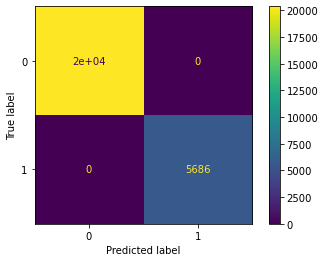

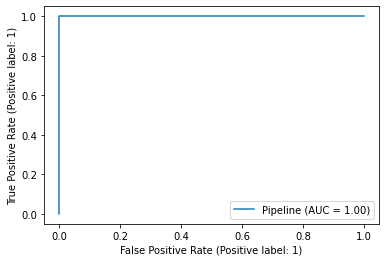

In [44]:
y_pred_dt_train = dt_pl.predict(x_train)
acc_dt_train = balanced_accuracy_score(y_train, y_pred_dt_train)
rc_dt_train = recall_score(y_train, y_pred_dt_train)
dt_y_pred_proba_train = dt_pl.predict_proba(x_train)[::,1]
auc_dt_train = metrics.roc_auc_score(y_train, dt_y_pred_proba_train)
cr_dt_train = classification_report(y_train,y_pred_dt_train)
print(f'''Decision Tree Default Train

Accuracy score : {acc_dt_train}
Recall score : {rc_dt_train}
AUC score : {auc_dt_train}

{cr_dt_train}
''')

plot_confusion_matrix(dt_pl, x_train, y_train)  
metrics.plot_roc_curve(dt_pl, x_train, y_train)
plt.show()

#### Data Test

Decision Tree Default Test

Accuracy score : 0.8501452081584024
Recall score : 0.7741027445460943
AUC score : 0.8501452081584023

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5094
           1       0.75      0.77      0.76      1421

    accuracy                           0.89      6515
   macro avg       0.84      0.85      0.85      6515
weighted avg       0.89      0.89      0.89      6515




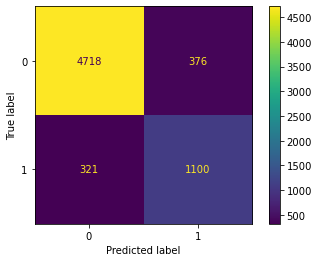

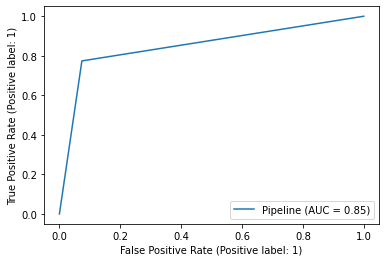

In [45]:
y_pred_dt_test = dt_pl.predict(x_test)
acc_dt_test = balanced_accuracy_score(y_test, y_pred_dt_test)
rc_dt_test = recall_score(y_test, y_pred_dt_test)
dt_y_pred_proba_test = dt_pl.predict_proba(x_test)[::,1]
auc_dt_test = metrics.roc_auc_score(y_test, dt_y_pred_proba_test)
cr_dt_test = classification_report(y_test,y_pred_dt_test)
print(f'''Decision Tree Default Test

Accuracy score : {acc_dt_test}
Recall score : {rc_dt_test}
AUC score : {auc_dt_test}

{cr_dt_test}
''')

plot_confusion_matrix(dt_pl, x_test, y_test)  
metrics.plot_roc_curve(dt_pl, x_test, y_test)
plt.show()

### KNN Default

#### Modeling

In [46]:
knn_pl = Pipeline([
            ("preprocess",transformer),
            ("model",knn)])
knn_pl.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot', OneHotEncoder(),
                                                  ['loan_intent',
                                                   'person_home_ownership']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'loan_grade',
                                                                           'mapping': {'A': 7,
                                                                                       'B': 6,
                                                                                       'C': 5,
                                                                                       'D': 4,
                                                                                       'E': 3,
                                                       

#### Data Train

KNN Default Train

Accuracy score : 0.7818446956177248
Recall score : 0.6123812873724939
AUC score : 0.9330749072879092

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     20373
           1       0.78      0.61      0.69      5686

    accuracy                           0.88     26059
   macro avg       0.84      0.78      0.80     26059
weighted avg       0.87      0.88      0.87     26059




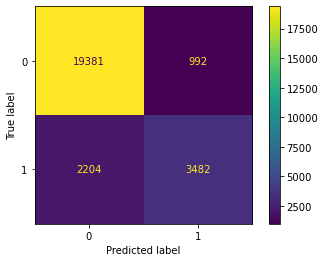

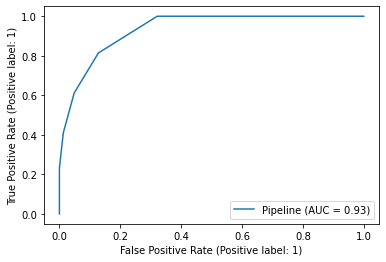

In [47]:
y_pred_knn_train = knn_pl.predict(x_train)
acc_knn_train = balanced_accuracy_score(y_train, y_pred_knn_train)
rc_knn_train = recall_score(y_train, y_pred_knn_train)
knn_y_pred_proba_train = knn_pl.predict_proba(x_train)[::,1]
auc_knn_train = metrics.roc_auc_score(y_train, knn_y_pred_proba_train)
cr_knn_train = classification_report(y_train,y_pred_knn_train)
print(f'''KNN Default Train

Accuracy score : {acc_knn_train}
Recall score : {rc_knn_train}
AUC score : {auc_knn_train}

{cr_knn_train}
''')

plot_confusion_matrix(knn_pl, x_train, y_train)  
metrics.plot_roc_curve(knn_pl, x_train, y_train)
plt.show()

#### Data Test

KNN Default Test

Accuracy score : 0.7078287795358589
Recall score : 0.49261083743842365
AUC score : 0.8118299267231364

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      5094
           1       0.64      0.49      0.56      1421

    accuracy                           0.83      6515
   macro avg       0.75      0.71      0.73      6515
weighted avg       0.82      0.83      0.82      6515




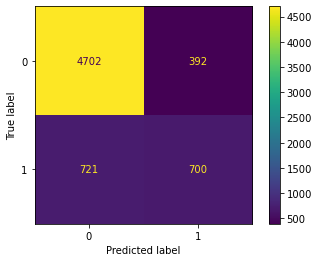

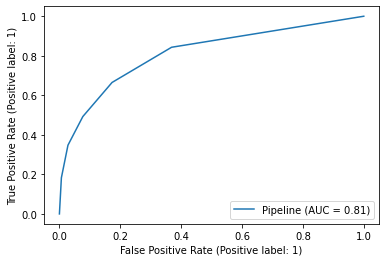

In [48]:
y_pred_knn_test = knn_pl.predict(x_test)
acc_knn_test = balanced_accuracy_score(y_test, y_pred_knn_test)
rc_knn_test = recall_score(y_test, y_pred_knn_test)
knn_y_pred_proba_test = knn_pl.predict_proba(x_test)[::,1]
auc_knn_test = metrics.roc_auc_score(y_test, knn_y_pred_proba_test)
cr_knn_test = classification_report(y_test,y_pred_knn_test)
print(f'''KNN Default Test

Accuracy score : {acc_knn_test}
Recall score : {rc_knn_test}
AUC score : {auc_knn_test}

{cr_knn_test}
''')

plot_confusion_matrix(knn_pl, x_test, y_test)  
metrics.plot_roc_curve(knn_pl, x_test, y_test)
plt.show()

### KNN Scalling

#### Modeling

In [49]:
knn_pl_sc = Pipeline([
            ("preprocess",transformer_sc),
            ("model",knn)])
knn_pl_sc.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalling', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('one hot', OneHotEncoder(),
                                                  ['loan_intent',
                                                   'person_home_ownership']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'loan_grade',
         

#### Data Train

KNN Scalling Train

Accuracy score : 0.8359918896678251
Recall score : 0.6860710517059444
AUC score : 0.9638377740886943

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     20373
           1       0.93      0.69      0.79      5686

    accuracy                           0.92     26059
   macro avg       0.92      0.84      0.87     26059
weighted avg       0.92      0.92      0.92     26059




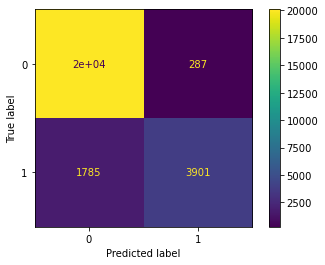

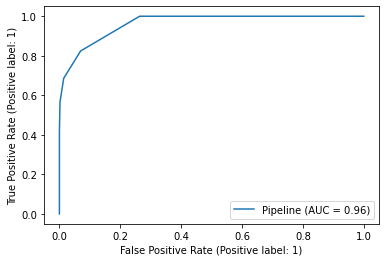

In [50]:
y_pred_knn_sc_train = knn_pl_sc.predict(x_train)
acc_knn_sc_train = balanced_accuracy_score(y_train, y_pred_knn_sc_train)
rc_knn_sc_train = recall_score(y_train, y_pred_knn_sc_train)
knn_sc_y_pred_proba_train = knn_pl_sc.predict_proba(x_train)[::,1]
auc_knn_sc_train = metrics.roc_auc_score(y_train, knn_sc_y_pred_proba_train)
cr_knn_sc_train = classification_report(y_train,y_pred_knn_sc_train)
print(f'''KNN Scalling Train

Accuracy score : {acc_knn_sc_train}
Recall score : {rc_knn_sc_train}
AUC score : {auc_knn_sc_train}

{cr_knn_sc_train}
''')

plot_confusion_matrix(knn_pl_sc, x_train, y_train)  
metrics.plot_roc_curve(knn_pl_sc, x_train, y_train)
plt.show()

#### Data Test

KNN Scalling Test

Accuracy score : 0.8000810656905628
Recall score : 0.6284306826178747
AUC score : 0.8739237866463754

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      5094
           1       0.86      0.63      0.73      1421

    accuracy                           0.90      6515
   macro avg       0.88      0.80      0.83      6515
weighted avg       0.89      0.90      0.89      6515




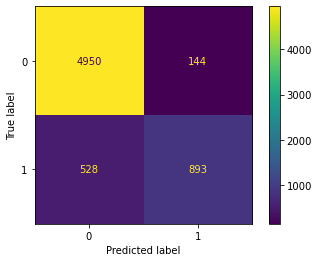

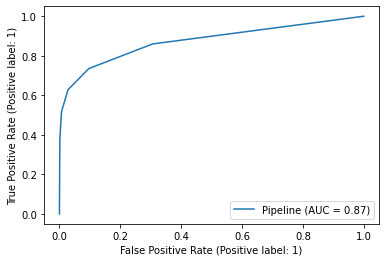

In [51]:
y_pred_knn_sc_test = knn_pl_sc.predict(x_test)
acc_knn_sc_test = balanced_accuracy_score(y_test, y_pred_knn_sc_test)
rc_knn_sc_test = recall_score(y_test, y_pred_knn_sc_test)
knn_sc_y_pred_proba_test = knn_pl_sc.predict_proba(x_test)[::,1]
auc_knn_sc_test = metrics.roc_auc_score(y_test, knn_sc_y_pred_proba_test)
cr_knn_sc_test = classification_report(y_test,y_pred_knn_sc_test)
print(f'''KNN Scalling Test

Accuracy score : {acc_knn_sc_test}
Recall score : {rc_knn_sc_test}
AUC score : {auc_knn_sc_test}

{cr_knn_sc_test}
''')

plot_confusion_matrix(knn_pl_sc, x_test, y_test)  
metrics.plot_roc_curve(knn_pl_sc, x_test, y_test)
plt.show()

### Logreg Default

#### Modeling

In [52]:
logreg=LogisticRegression(random_state=76)
logreg_pl = Pipeline([
            ("preprocess",transformer),
            ("model",logreg)])
logreg_pl.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot', OneHotEncoder(),
                                                  ['loan_intent',
                                                   'person_home_ownership']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'loan_grade',
                                                                           'mapping': {'A': 7,
                                                                                       'B': 6,
                                                                                       'C': 5,
                                                                                       'D': 4,
                                                                                       'E': 3,
                                                       

#### Data Train

Logistic Regression Default Train

Accuracy score : 0.5703372301787974
Recall score : 0.1577558916637355
AUC score : 0.7603923202308602

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     20373
           1       0.72      0.16      0.26      5686

    accuracy                           0.80     26059
   macro avg       0.76      0.57      0.57     26059
weighted avg       0.79      0.80      0.75     26059




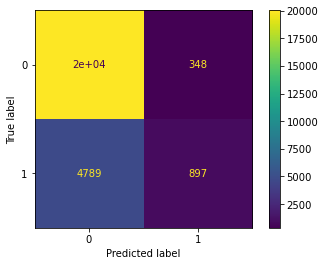

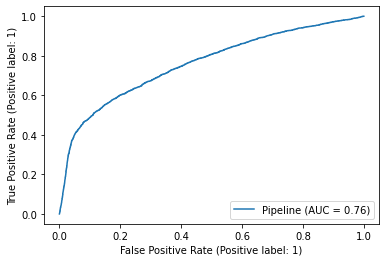

In [53]:
y_pred_logreg_train = logreg_pl.predict(x_train)
acc_logreg_train = balanced_accuracy_score(y_train, y_pred_logreg_train)
rc_logreg_train = recall_score(y_train, y_pred_logreg_train)
logreg_y_pred_proba_train = logreg_pl.predict_proba(x_train)[::,1]
auc_logreg_train = metrics.roc_auc_score(y_train, logreg_y_pred_proba_train)
cr_logreg_train = classification_report(y_train,y_pred_logreg_train)
print(f'''Logistic Regression Default Train

Accuracy score : {acc_logreg_train}
Recall score : {rc_logreg_train}
AUC score : {auc_logreg_train}

{cr_logreg_train}
''')

plot_confusion_matrix(logreg_pl, x_train, y_train)  
metrics.plot_roc_curve(logreg_pl, x_train, y_train)
plt.show()

#### Data Test

Logistic Regression Default Test

Accuracy score : 0.5800564448191039
Recall score : 0.175228712174525
AUC score : 0.7653546126626598

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      5094
           1       0.76      0.18      0.29      1421

    accuracy                           0.81      6515
   macro avg       0.79      0.58      0.59      6515
weighted avg       0.80      0.81      0.76      6515




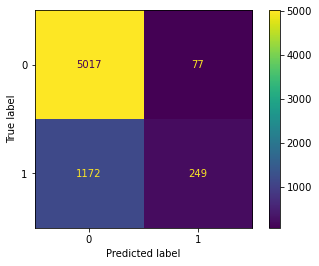

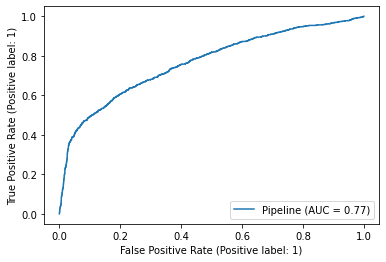

In [54]:
y_pred_logreg_test = logreg_pl.predict(x_test)
acc_logreg_test = balanced_accuracy_score(y_test, y_pred_logreg_test)
rc_logreg_test = recall_score(y_test, y_pred_logreg_test)
logreg_y_pred_proba_test = logreg_pl.predict_proba(x_test)[::,1]
auc_logreg_test = metrics.roc_auc_score(y_test, logreg_y_pred_proba_test)
cr_logreg_test = classification_report(y_test,y_pred_logreg_test)
print(f'''Logistic Regression Default Test

Accuracy score : {acc_logreg_test}
Recall score : {rc_logreg_test}
AUC score : {auc_logreg_test}

{cr_logreg_test}
''')

plot_confusion_matrix(logreg_pl, x_test, y_test)  
metrics.plot_roc_curve(logreg_pl, x_test, y_test)
plt.show()

### Logreg Scalling

#### Modeling

In [55]:
logreg_pl_sc = Pipeline([
            ("preprocess",transformer_sc),
            ("model",logreg)])
logreg_pl_sc.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalling', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('one hot', OneHotEncoder(),
                                                  ['loan_intent',
                                                   'person_home_ownership']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'loan_grade',
         

#### Data Train

Logistic Regression Scalling Train

Accuracy score : 0.7280446027006114
Recall score : 0.5061554695743933
AUC score : 0.8633943882918429

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     20373
           1       0.74      0.51      0.60      5686

    accuracy                           0.85     26059
   macro avg       0.81      0.73      0.76     26059
weighted avg       0.84      0.85      0.84     26059




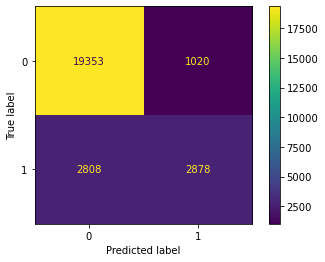

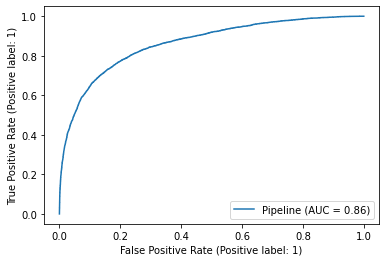

In [56]:
y_pred_logreg_sc_train = logreg_pl_sc.predict(x_train)
acc_logreg_sc_train = balanced_accuracy_score(y_train, y_pred_logreg_sc_train)
rc_logreg_sc_train = recall_score(y_train, y_pred_logreg_sc_train)
logreg_sc_y_pred_proba_train = logreg_pl_sc.predict_proba(x_train)[::,1]
auc_logreg_sc_train = metrics.roc_auc_score(y_train, logreg_sc_y_pred_proba_train)
cr_logreg_sc_train = classification_report(y_train,y_pred_logreg_sc_train)
print(f'''Logistic Regression Scalling Train

Accuracy score : {acc_logreg_sc_train}
Recall score : {rc_logreg_sc_train}
AUC score : {auc_logreg_sc_train}

{cr_logreg_sc_train}
''')

plot_confusion_matrix(logreg_pl_sc, x_train, y_train)  
metrics.plot_roc_curve(logreg_pl_sc, x_train, y_train)
plt.show()

#### Data Test

Logistic Regression Scalling Test

Accuracy score : 0.7330264220549517
Recall score : 0.5151301900070373
AUC score : 0.8647830359957638

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5094
           1       0.75      0.52      0.61      1421

    accuracy                           0.86      6515
   macro avg       0.81      0.73      0.76      6515
weighted avg       0.85      0.86      0.85      6515




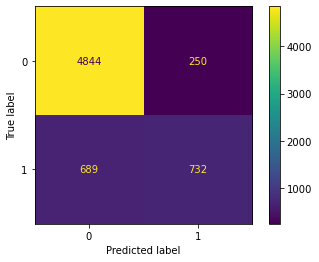

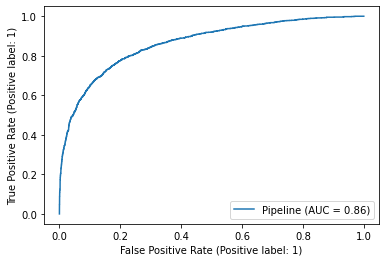

In [57]:
y_pred_logreg_sc_test = logreg_pl_sc.predict(x_test)
acc_logreg_sc_test = balanced_accuracy_score(y_test, y_pred_logreg_sc_test)
rc_logreg_sc_test = recall_score(y_test, y_pred_logreg_sc_test)
logreg_sc_y_pred_proba_test = logreg_pl_sc.predict_proba(x_test)[::,1]
auc_logreg_sc_test = metrics.roc_auc_score(y_test, logreg_sc_y_pred_proba_test)
cr_logreg_sc_test = classification_report(y_test,y_pred_logreg_sc_test)
print(f'''Logistic Regression Scalling Test

Accuracy score : {acc_logreg_sc_test}
Recall score : {rc_logreg_sc_test}
AUC score : {auc_logreg_sc_test}

{cr_logreg_sc_test}
''')

plot_confusion_matrix(logreg_pl_sc, x_test, y_test)  
metrics.plot_roc_curve(logreg_pl_sc, x_test, y_test)
plt.show()

### Comparison Default & Scalling with Data Train & Test

In [58]:
pd.DataFrame({"Model":["Decision Tree Default Train","Decision Tree Default Test",
                      "KNN Default Train","KNN Default Test",
                      "KNN Scalling Train","KNN Scalling Test",
                      "Logreg Default Train","Logreg Default Test",
                      "Logreg Scalling Train","Logreg Scalling Test",],
             "Accuracy Score":[acc_dt_train,acc_dt_test,
                              acc_knn_train,acc_knn_test,
                              acc_knn_sc_train,acc_knn_sc_test,
                              acc_logreg_train,acc_logreg_test,
                              acc_logreg_sc_train,acc_logreg_sc_test,],
             "Recall Score":[rc_dt_train,rc_dt_test,
                             rc_knn_train,rc_knn_test,
                             rc_knn_sc_train,rc_knn_sc_test,
                             rc_logreg_train,rc_logreg_test,
                             rc_logreg_sc_train,rc_logreg_sc_test],
             "AUC Score":[auc_dt_train,auc_dt_test,
                          auc_knn_train,auc_knn_test,
                          auc_knn_sc_train,auc_knn_sc_test,
                          auc_logreg_train,auc_logreg_test,
                          auc_logreg_sc_train,auc_logreg_sc_test,],
             })

,Model,Accuracy Score,Recall Score,AUC Score
0,Decision Tree Default Train,1.000000,1.000000,1.000000
1,Decision Tree Default Test,0.850145,0.774103,0.850145
2,KNN Default Train,0.781845,0.612381,0.933075
3,KNN Default Test,0.707829,0.492611,0.811830
4,KNN Scalling Train,0.835992,0.686071,0.963838
5,KNN Scalling Test,0.800081,0.628431,0.873924
6,Logreg Default Train,0.570337,0.157756,0.760392
7,Logreg Default Test,0.580056,0.175229,0.765355
8,Logreg Scalling Train,0.728045,0.506155,0.863394
9,Logreg Scalling Test,0.733026,0.515130,0.864783


KNN with scalling have the highest score

# Handle Imbalance

For this case, we use Undersampling method

## Undersampling

In [59]:
from imblearn.pipeline import Pipeline

nm = NearMiss()
dt_us=Pipeline([
            ("preprocess",transformer_sc),
            ("resampling",nm),
            ("model",dt)])
dt_us.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalling', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('one hot', OneHotEncoder(),
                                                  ['loan_intent',
                                                   'person_home_ownership']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'loan_grade',
         

## Data Train

Score Decision Tree Undersampling Train

Accuracy score : 0.7885436607274334
Recall score : 1.0
AUC score : 0.7885436607274334

              precision    recall  f1-score   support

           0       1.00      0.58      0.73     20373
           1       0.40      1.00      0.57      5686

    accuracy                           0.67     26059
   macro avg       0.70      0.79      0.65     26059
weighted avg       0.87      0.67      0.70     26059




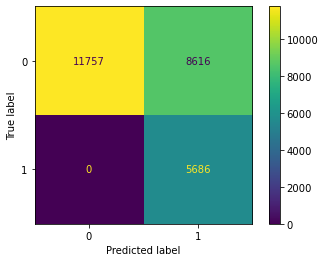

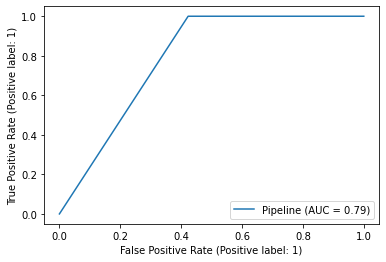

In [60]:
y_pred_us_train = dt_us.predict(x_train)
acc_us_train = balanced_accuracy_score(y_train, y_pred_us_train)
rc_us_train = recall_score(y_train, y_pred_us_train)
dt_us_y_pred_proba_train = dt_us.predict_proba(x_train)[::,1]
auc_dt_us_train = metrics.roc_auc_score(y_train, dt_us_y_pred_proba_train)
cr_us_train = classification_report(y_train,y_pred_us_train)
print(f'''Score Decision Tree Undersampling Train

Accuracy score : {acc_us_train}
Recall score : {rc_us_train}
AUC score : {auc_dt_us_train}

{cr_us_train}
''')

plot_confusion_matrix(dt_us, x_train, y_train)  
metrics.plot_roc_curve(dt_us, x_train, y_train)
plt.show()

## Data Test

Score Decision Tree Undersampling Test

Accuracy score : 0.7062602385497474
Recall score : 0.8620689655172413
AUC score : 0.7062602385497475

              precision    recall  f1-score   support

           0       0.93      0.55      0.69      5094
           1       0.35      0.86      0.50      1421

    accuracy                           0.62      6515
   macro avg       0.64      0.71      0.59      6515
weighted avg       0.81      0.62      0.65      6515




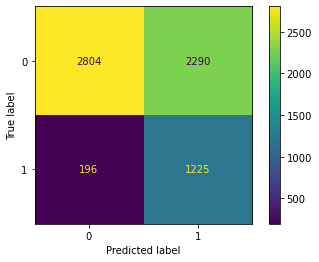

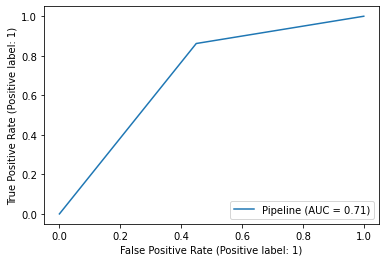

In [61]:
y_pred_us_test = dt_us.predict(x_test)
acc_us_test = balanced_accuracy_score(y_test, y_pred_us_test)
rc_us_test = recall_score(y_test, y_pred_us_test)
dt_us_y_pred_proba_test = dt_us.predict_proba(x_test)[::,1]
auc_dt_us_test = metrics.roc_auc_score(y_test, dt_us_y_pred_proba_test)
cr_us_test = classification_report(y_test,y_pred_us_test)
print(f'''Score Decision Tree Undersampling Test

Accuracy score : {acc_us_test}
Recall score : {rc_us_test}
AUC score : {auc_dt_us_test}

{cr_us_test}
''')

plot_confusion_matrix(dt_us, x_test, y_test)  
metrics.plot_roc_curve(dt_us, x_test, y_test)
plt.show()

## Comparison Default & Imbalance Handling

In [62]:
pd.DataFrame({"Model":["Decision Tree Default Train","Decision Tree Default Test",
                      "KNN Default Train","KNN Default Test",
                      "KNN Scalling Train","KNN Scalling Test",
                      "Logreg Default Train","Logreg Default Test",
                      "Logreg Scalling Train","Logreg Scalling Test",
                      "Decision Tree Undersampling Train","Decision Tree Undersampling Test",],
             "Accuracy Score":[acc_dt_train,acc_dt_test,
                              acc_knn_train,acc_knn_test,
                              acc_knn_sc_train,acc_knn_sc_test,
                              acc_logreg_train,acc_logreg_test,
                              acc_logreg_sc_train,acc_logreg_sc_test,
                              acc_us_train,acc_us_test],
             "Recall Score":[rc_dt_train,rc_dt_test,
                             rc_knn_train,rc_knn_test,
                             rc_knn_sc_train,rc_knn_sc_test,
                             rc_logreg_train,rc_logreg_test,
                             rc_logreg_sc_train,rc_logreg_sc_test,
                             rc_us_train,rc_us_test],
             "AUC Score":[auc_dt_train,auc_dt_test,
                          auc_knn_train,auc_knn_test,
                          auc_knn_sc_train,auc_knn_sc_test,
                          auc_logreg_train,auc_logreg_test,
                          auc_logreg_sc_train,auc_logreg_sc_test,
                          auc_dt_us_train,auc_dt_us_test],
             })

,Model,Accuracy Score,Recall Score,AUC Score
0,Decision Tree Default Train,1.000000,1.000000,1.000000
1,Decision Tree Default Test,0.850145,0.774103,0.850145
2,KNN Default Train,0.781845,0.612381,0.933075
3,KNN Default Test,0.707829,0.492611,0.811830
4,KNN Scalling Train,0.835992,0.686071,0.963838
5,KNN Scalling Test,0.800081,0.628431,0.873924
6,Logreg Default Train,0.570337,0.157756,0.760392
7,Logreg Default Test,0.580056,0.175229,0.765355
8,Logreg Scalling Train,0.728045,0.506155,0.863394
9,Logreg Scalling Test,0.733026,0.515130,0.864783


Selected Model : **KNN Scalling Undersampling**

# Hyperparameter Tuning

## Grid Search

In [63]:
model = Pipeline([
            ("preprocess",transformer),
            ("resampling",nm),
            ("model",dt)])

In [64]:
model.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('one hot', OneHotEncoder(),
                                    ['loan_intent', 'person_home_ownership']),
                                   ('ordinal',
                                    OrdinalEncoder(mapping=[{'col': 'loan_grade',
                                                             'mapping': {'A': 7,
                                                                         'B': 6,
                                                                         'C': 5,
                                                                         'D': 4,
                                                                         'E': 3,
                                                                         'F': 2,
                                                                         'G': 1}}]),
                                    ['loan_grade'])])),
  ('resampli

In [65]:
hyperparam_space={
    'resampling__n_neighbors': [3,5,7],
    "model__criterion":["gini", "entropy"],
    "model__max_depth": [10,25,40],
    "model__class_weight": ["dict","balanced"],
}

In [66]:
skfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(model,
                           param_grid=hyperparam_space,
                           cv=skfold,
                           scoring="recall",
                           n_jobs=-1)

In [67]:
grid_search.fit(x_train,y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8501566574387939
{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 40, 'resampling__n_neighbors': 7}


## Scoring Tuning Data Train

In [68]:
acc_model=grid_search.best_estimator_
acc_model.fit(x_train, y_train)
y_pred_acc_tuning_train = acc_model.predict(x_train)

recall_tun_train = recall_score(y_train, y_pred_acc_tuning_train)
acc_tun_train = balanced_accuracy_score(y_train, y_pred_acc_tuning_train)
acc_tun_y_pred_proba_train = acc_model.predict_proba(x_train)[::,1]
auc_tun_train = metrics.roc_auc_score(y_train, acc_tun_y_pred_proba_train)
cr_tun_train = classification_report(y_train,y_pred_acc_tuning_train)
print(f'''Score Tuning Train
    
recall score : {recall_tun_train}
Accuracy score : {acc_tun_train}
AUC score : {auc_tun_train}

{cr_tun_train}
''')

Score Tuning Train
    
recall score : 1.0
Accuracy score : 0.7869974966867914
AUC score : 0.7869471172343842

              precision    recall  f1-score   support

           0       1.00      0.57      0.73     20373
           1       0.40      1.00      0.57      5686

    accuracy                           0.67     26059
   macro avg       0.70      0.79      0.65     26059
weighted avg       0.87      0.67      0.69     26059




## Scoring Tuning Data Test

Score Tuning Test

recall score : 0.8515130190007038
Accuracy score : 0.6984302433048277
AUC score : 0.6984302433048277

              precision    recall  f1-score   support

           0       0.93      0.55      0.69      5094
           1       0.34      0.85      0.49      1421

    accuracy                           0.61      6515
   macro avg       0.64      0.70      0.59      6515
weighted avg       0.80      0.61      0.64      6515




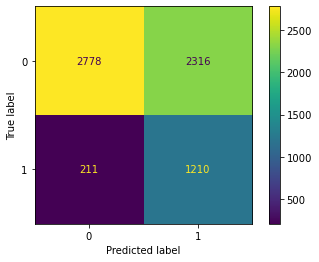

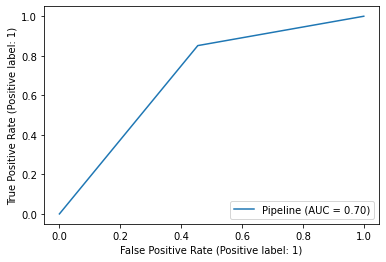

In [69]:
y_pred_acc_tuning_test = acc_model.predict(x_test)

recall_tun_test = recall_score(y_test, y_pred_acc_tuning_test)
acc_tun_test = balanced_accuracy_score(y_test, y_pred_acc_tuning_test)
acc_tun_y_pred_proba_test = acc_model.predict_proba(x_test)[::,1]
auc_tun_test = metrics.roc_auc_score(y_test, acc_tun_y_pred_proba_test)
cr_tun_test = classification_report(y_test,y_pred_acc_tuning_test)
print(f'''Score Tuning Test

recall score : {recall_tun_test}
Accuracy score : {acc_tun_test}
AUC score : {auc_tun_test}

{cr_tun_test}
''')

plot_confusion_matrix(acc_model, x_test, y_test)  
metrics.plot_roc_curve(acc_model, x_test, y_test)
plt.show()

## Comparing Scoring Default and Tuning

In [70]:
pd.DataFrame({"Model":["Decision Tree Default Train","Decision Tree Default Test",
                      "KNN Default Train","KNN Default Test",
                      "KNN Scalling Train","KNN Scalling Test",
                      "Logreg Default Train","Logreg Default Test",
                      "Logreg Scalling Train","Logreg Scalling Test",
                      "Decision Tree Undersampling Train","Decision Tree Undersampling Test",
                      "Decision Tree Undersampling Tuning Train","Decision Tree Undersampling Tuning Test"],
             "Accuracy Score":[acc_dt_train,acc_dt_test,
                              acc_knn_train,acc_knn_test,
                              acc_knn_sc_train,acc_knn_sc_test,
                              acc_logreg_train,acc_logreg_test,
                              acc_logreg_sc_train,acc_logreg_sc_test,
                              acc_us_train,acc_us_test,
                              acc_tun_train,acc_tun_test],
             "Recall Score":[rc_dt_train,rc_dt_test,
                             rc_knn_train,rc_knn_test,
                             rc_knn_sc_train,rc_knn_sc_test,
                             rc_logreg_train,rc_logreg_test,
                             rc_logreg_sc_train,rc_logreg_sc_test,
                             rc_us_train,rc_us_test,
                             recall_tun_train,recall_tun_test],
             "AUC Score":[auc_dt_train,auc_dt_test,
                          auc_knn_train,auc_knn_test,
                          auc_knn_sc_train,auc_knn_sc_test,
                          auc_logreg_train,auc_logreg_test,
                          auc_logreg_sc_train,auc_logreg_sc_test,
                          auc_dt_us_train,auc_dt_us_test,
                          auc_tun_train,auc_tun_test],
             })

,Model,Accuracy Score,Recall Score,AUC Score
0,Decision Tree Default Train,1.000000,1.000000,1.000000
1,Decision Tree Default Test,0.850145,0.774103,0.850145
2,KNN Default Train,0.781845,0.612381,0.933075
3,KNN Default Test,0.707829,0.492611,0.811830
4,KNN Scalling Train,0.835992,0.686071,0.963838
5,KNN Scalling Test,0.800081,0.628431,0.873924
6,Logreg Default Train,0.570337,0.157756,0.760392
7,Logreg Default Test,0.580056,0.175229,0.765355
8,Logreg Scalling Train,0.728045,0.506155,0.863394
9,Logreg Scalling Test,0.733026,0.515130,0.864783


Selected Model : **KNN Undersampling**

# Interpretable & Explainable

In [71]:
df_shap = pd.DataFrame(transformer.fit_transform(x_train))
df_shap.columns = features
x_train_shap,y_train_shap = nm.fit_resample(df_shap,y_train)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


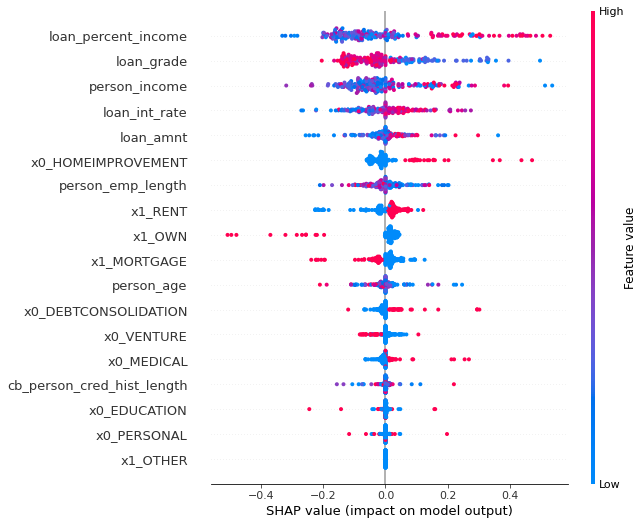

In [72]:
ex = shap.KernelExplainer(acc_model[2].predict, shap.sample(x_train_shap,200))
shap_values = ex.shap_values(shap.sample(x_train_shap,200))
shap.summary_plot(shap_values, shap.sample(x_train_shap,200),max_display = 20)

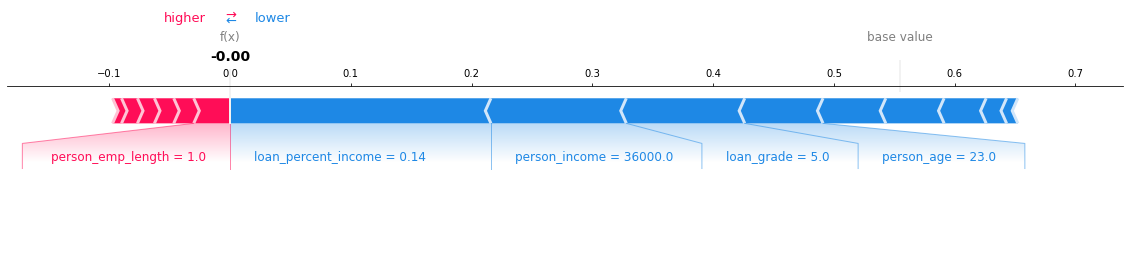

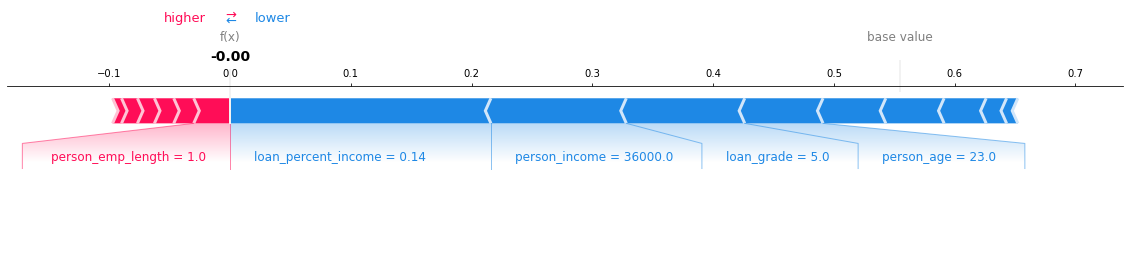

In [73]:
shap.initjs()
shap_values_1 = ex.shap_values(x_train_shap.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values_1, x_train_shap.iloc[0,:],matplotlib=True, show=False)

# Conclusion

## Process Summary

In [74]:
pd.DataFrame({"Model":["Decision Tree Default Train","Decision Tree Default Test",
                      "KNN Default Train","KNN Default Test",
                      "KNN Scalling Train","KNN Scalling Test",
                      "Logreg Default Train","Logreg Default Test",
                      "Logreg Scalling Train","Logreg Scalling Test",
                      "Decision Tree Undersampling Train","Decision Tree Undersampling Test",
                      "Decision Tree Undersampling Tuning Train","Decision Tree Undersampling Tuning Test"],
             "Accuracy Score":[acc_dt_train,acc_dt_test,
                              acc_knn_train,acc_knn_test,
                              acc_knn_sc_train,acc_knn_sc_test,
                              acc_logreg_train,acc_logreg_test,
                              acc_logreg_sc_train,acc_logreg_sc_test,
                              acc_us_train,acc_us_test,
                              acc_tun_train,acc_tun_test],
             "Recall Score":[rc_dt_train,rc_dt_test,
                             rc_knn_train,rc_knn_test,
                             rc_knn_sc_train,rc_knn_sc_test,
                             rc_logreg_train,rc_logreg_test,
                             rc_logreg_sc_train,rc_logreg_sc_test,
                             rc_us_train,rc_us_test,
                             recall_tun_train,recall_tun_test],
             "AUC Score":[auc_dt_train,auc_dt_test,
                          auc_knn_train,auc_knn_test,
                          auc_knn_sc_train,auc_knn_sc_test,
                          auc_logreg_train,auc_logreg_test,
                          auc_logreg_sc_train,auc_logreg_sc_test,
                          auc_dt_us_train,auc_dt_us_test,
                          auc_tun_train,auc_tun_test],
             })

,Model,Accuracy Score,Recall Score,AUC Score
0,Decision Tree Default Train,1.000000,1.000000,1.000000
1,Decision Tree Default Test,0.850145,0.774103,0.850145
2,KNN Default Train,0.781845,0.612381,0.933075
3,KNN Default Test,0.707829,0.492611,0.811830
4,KNN Scalling Train,0.835992,0.686071,0.963838
5,KNN Scalling Test,0.800081,0.628431,0.873924
6,Logreg Default Train,0.570337,0.157756,0.760392
7,Logreg Default Test,0.580056,0.175229,0.765355
8,Logreg Scalling Train,0.728045,0.506155,0.863394
9,Logreg Scalling Test,0.733026,0.515130,0.864783


In [75]:
print("Classification Final Model \n",cr_us_test)

Classification Final Model 
               precision    recall  f1-score   support

           0       0.93      0.55      0.69      5094
           1       0.35      0.86      0.50      1421

    accuracy                           0.62      6515
   macro avg       0.64      0.71      0.59      6515
weighted avg       0.81      0.62      0.65      6515



<p style='text-align: justify;'> Dataset contains information about customer who have loan in our company. To measure our model performance, i used recall metric because we want to minimalize false negative. I tried 3 basic classification models and did the benchmark and get Decision Tree have best benchmark score. After that i tried to gave treatment scalling to model with robust method because numeric feature data have outliers and Decision Tree still gave highest score performance. This dataset have imbalance performance between class 1 and class 0, because of that i tried to get same proportion with undersampling method because if i use oversampling, dataset will overfitting.

To optimize the model, I did hyperparameter tunning using grid search and found default model gave better performance. The result focus on recall to minmize the customers who make loan which predicted will repay but actually not. To make our model is explainable and interpretable, i used SHAP method. I also do analytics for raw data set and predicted data set to answer the business problem to help Company reach their goals as mentioned in the problem statement. From the SHAP result, we know  `loan_percent_income`,`person_income`,`loan_grade`,`loan_int_rate`,`loan_amount`,`person_emp_length` gave most impact in this dataset. The interpretation of SHAP are:
* `loan_percent_income` : More higher `loan_percent_income` increase probability customer to not repay
* `person_income` : More lower `person_income` increase probability customer to repay
* `loan_grade` : More higher `loan_grade` increase probability customer to repay
* `loan_int_rate` : More lower `loan_int_rate` increase probability customer to repay
* `loan_amount` : More lower `loan_amount` increase probability customer to repay
* `person_emp_length` : More lower `person_emp_length` increase probability customer to not repay
* etc

## Business Insight

* Our Data customer who use our loan product show their age between 20 and 30 and annual income between 50000 and 70000, and their employment length is low (usually their financial still not stable).
* The average percent income from interest is 0.17%
* The highest home status from customer is Rent and their loan purpose is education
* `loan_percent_income`,`person_income`,`loan_grade`,`loan_int_rate`,`loan_amount`,`person_emp_length` are most influence factor to customer repay or not.
* Age have small effect to this case
* Average loan amount more than 10800 have more probability to not repay
* Average employee length more than 5 years have more probability to repay
* Average person income under 50000 have more probability to not repay

## Recommendation

* Business Development and Marketing team can focus to customer with age >20 and <30 years and annual income >50000 and <70000 to boost the growth beside they will repay or not.
* Because of the average percent loan income from interest, we can promote the loan length which loan rate is 0.17%
* Team Marketing can give promotion or get some agreement about people who work in home rental and some shcool or university to attract people use our product.
* Gather more user activity data to make better prediction.
* Make screening before agree the customer based on `loan_percent_income`,`person_income`,`loan_grade`,`loan_int_rate`,`loan_amount`,`person_emp_length`.
* We can use third party or make some credit score to scoring customer because `loan_grade` become one of influence factor to predict customer will repay or not
* Company must aware for Loan intent Medical & Debtcons because there are have more customer who not repay than other intention
* Company must using loan grade because it feature have the highest effect

## Save Model

In [76]:
import pickle
p1_model = acc_model.fit(x_train, y_train)
file_name='dt cs.pickle'
pickle.dump(p1_model,open(file_name,'wb'))